<a href="https://www.kaggle.com/code/zainabs1/end-to-end-churn-analysis?scriptVersionId=297431677" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Executive Summary

This project analyzes customer churn behavior to identify high-risk segments and key drivers of attrition.

Overall churn rate: **~20.4%**

### Key Findings

* Customers falgged as High-Value Risk (multiple products + high balance) show the strongest churn probability.
* Single-product customers are more likely to churn than multi-product customers.
* Inactive members have higher churn risk, while active membership strongly reduces churn likelihood.
* Churn probability increases with age.
* Customers in Germany demonstrate higher relative churn risk.
* Balance alone is not a strong churn driver; engagement signals are more informative.

### Feature Engineering Impact

Behavioral flags derived from EDA (e.g., `single_product_flag`, `low_engagement_risk_flag`, `high_value_risk_flag`) show stronger predictive power than several raw numerical features, confirming that combined behavioral indicators are more effective than isolated attributes.

### Recommendations

* Launch targeted retention programs for high-value customers.
* Increase cross-sell initiatives for single-product users.
* Implement early re-engagement campaigns for inactive members.
* Encourage activity through loyalty programs or engagement-based incentives.
* Apply region-specific retention strategies in higher-risk markets.


This analysis combines exploratory data analysis, feature engineering, and interpretable modeling to provide actionable insights for reducing customer attrition.

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Dataset Loading

In [2]:
#load the dataset
Churn = pd.read_csv("/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv")

In [3]:
#inspect the dataset
Churn.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
Churn.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
#check for missing values
Churn.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [7]:
#check for duplicates
Churn.duplicated().sum()

np.int64(0)

## Exploratory Data Analysis (EDA)
The **goal** of this analysis is to understand **who churns**, **why they churn**, and **which signals *matter most*** for prediction.

#### 1. Target Variable Overview
What percentage of customers churn?

In [8]:
#reporting 
churn_count = Churn['churn'].value_counts().sort_index()
churn_pct = Churn['churn'].value_counts(normalize=True) * 100

print('\nChurn Count:')
print(f"Retained: {churn_count[0]}")
print(f"Churned: {churn_count[1]}")


Churn Count:
Retained: 7963
Churned: 2037


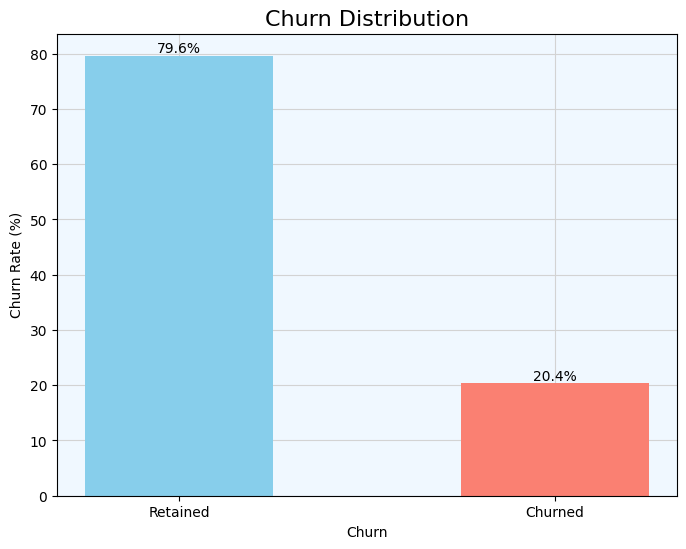

In [9]:
#visualization
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    churn_pct.index,
    churn_pct.values,
    width=0.5,
    color=['skyblue', 'salmon'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Distribution', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Churn')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Retained', 'Churned'])

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

#### 2. Demographic vs. Churn Analysis
Does churn increase with age?

In [10]:
#derive age_group
Churn['age_group'] = pd.cut(
    Churn['age'], 
    bins=[17, 29, 44, 59, 120], 
    labels=['18-29', '30-44', '45-59', '60+']
)

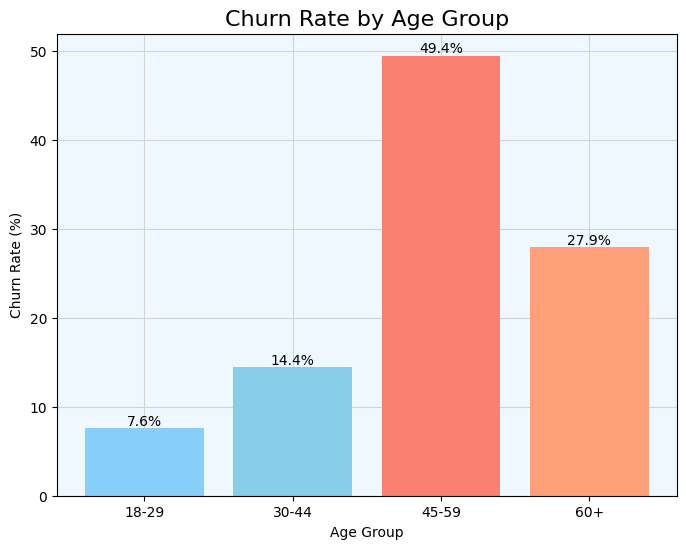

In [11]:
age_churn_pct = (
    Churn.groupby('age_group', observed=False)['churn']
    .mean()
    .sort_index() * 100
)

#visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(
    age_churn_pct.index, 
    age_churn_pct.values,
    color=['lightskyblue', 'skyblue', 'salmon', 'lightsalmon'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Age Group', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Age Group')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

Are there gender-based churn differences?

In [12]:
gender_count = Churn['gender'].value_counts().sort_index()

print('\nChurn Count:')
print(f"Male: {gender_count['Male']}")
print(f"Female: {gender_count['Female']}")


Churn Count:
Male: 5457
Female: 4543


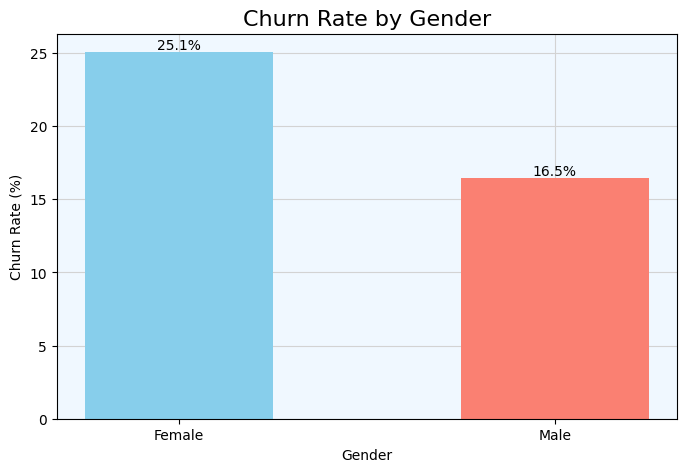

In [13]:
gender_churn_pct = (
    Churn.groupby('gender')['churn']
    .mean() * 100
)

#visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(
    gender_churn_pct.index,
    gender_churn_pct.values,
    width=0.5,
    color=['skyblue', 'salmon'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Gender', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Gender')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')
    
plt.show()

Do some countries churn more than others?

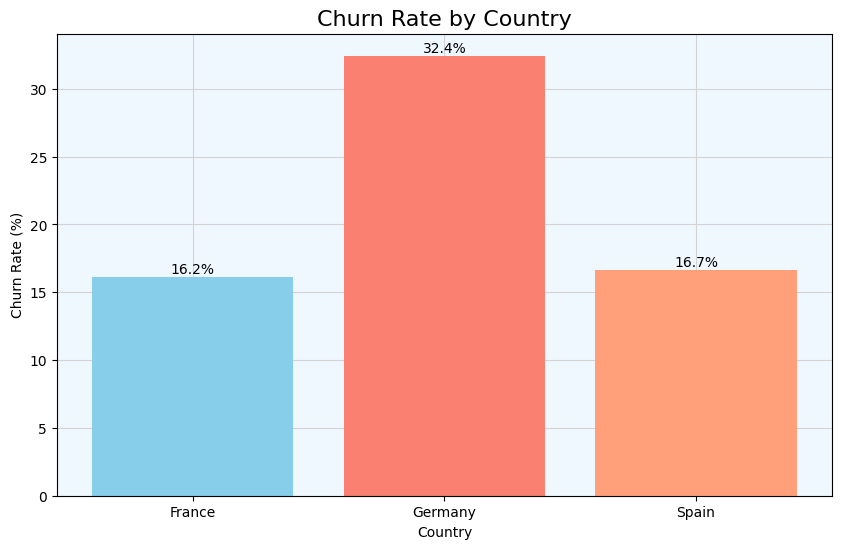

In [14]:
country_churn_pct = (
    Churn.groupby('country')['churn']
    .mean() * 100
)

#visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    country_churn_pct.index, 
    country_churn_pct.values,
    color=['skyblue', 'salmon', 'lightsalmon'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Country', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Country')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')
    
plt.show()

#### 3. Tenure and Loyalty Analysis
Do newer customers churn more?

In [15]:
#derive tenure_bucket
Churn['tenure_bucket'] = pd.cut(
    Churn['tenure'],
    bins=[-0.1, 2, 5, 10],
    labels=['0–2 yrs', '3–5 yrs', '6–10 yrs']
)

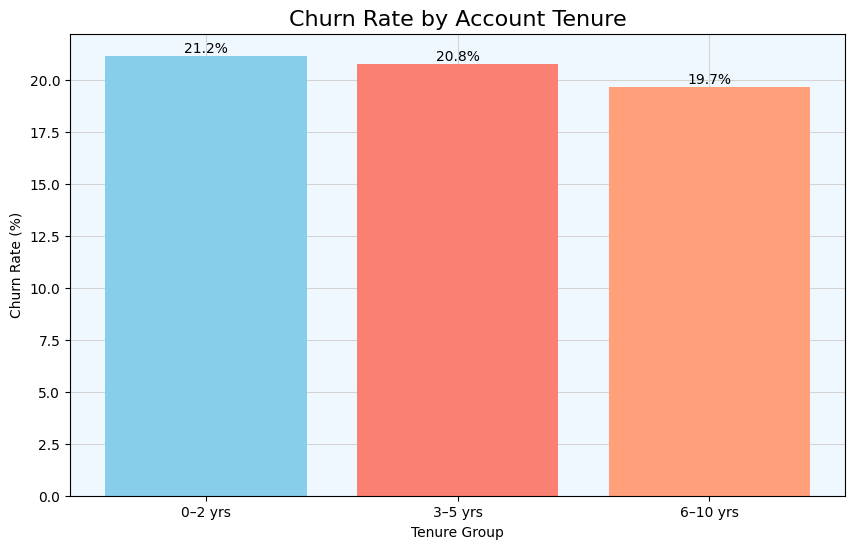

In [16]:
tenure_churn_pct = (
    Churn.groupby('tenure_bucket', observed=False)['churn']
    .mean()
    .sort_index() * 100
)

#visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    tenure_churn_pct.index, 
    tenure_churn_pct.values,
    color=['skyblue', 'salmon', 'lightsalmon'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Account Tenure', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Tenure Group')

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

Is long-term loyalty protective?

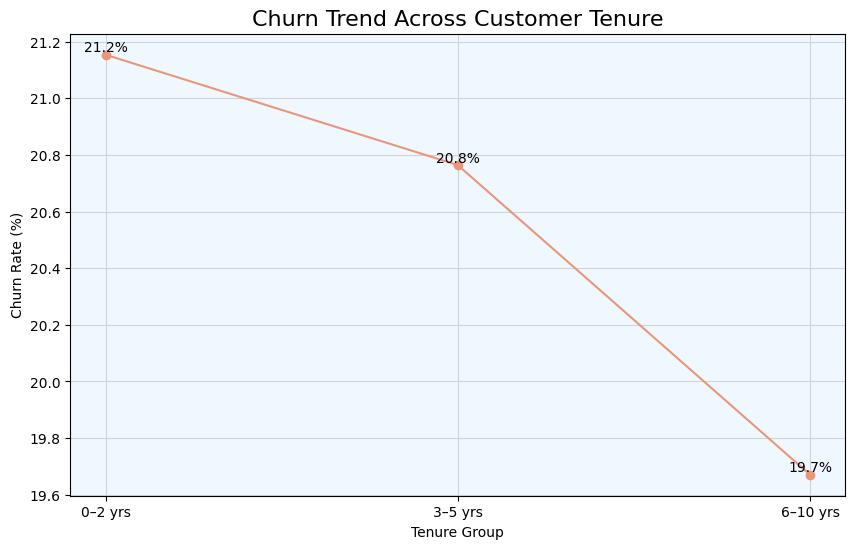

In [17]:
#visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    tenure_churn_pct.index, 
    tenure_churn_pct.values,
    color='darksalmon',
    marker='o'
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Trend Across Customer Tenure', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Tenure Group')

for x, y in zip(tenure_churn_pct.index, tenure_churn_pct.values):
    ax.text(x, y, f'{y:.1f}%', ha='center', va='bottom')

plt.show()

#### 4. Financial Behavior Analysis
Do low-balance customers churn more?

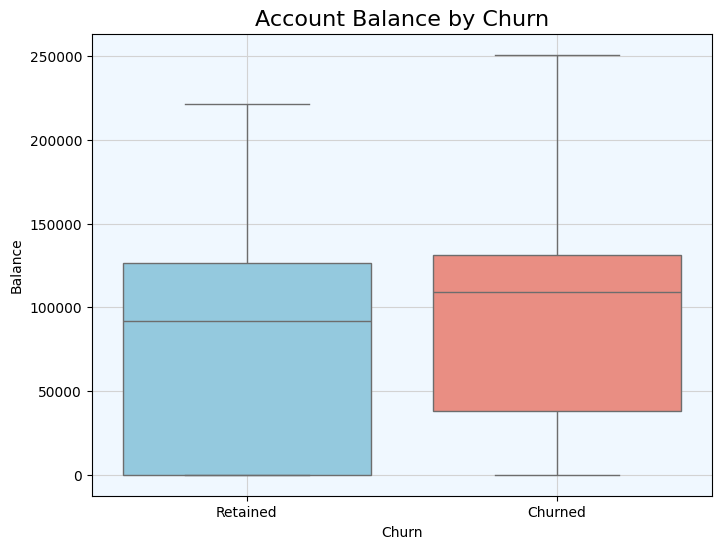

In [18]:
#visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    x='churn',
    y='balance',
    hue='churn',
    data=Churn,
    ax=ax,
    palette=['skyblue', 'salmon'],
    legend=False,
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Account Balance by Churn', fontsize=16)
ax.set_ylabel('Balance')
ax.set_xlabel('Churn')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Retained', 'Churned'])

plt.show()

The overlap is large; indicating that `balance` could be useful but is **not** sufficient on its own.  

This feature looks to be contributing **non-linearly**, i.e., working best **in combination** with other features. 

Therefore, let us combine it with `active_member` and `products_number`!

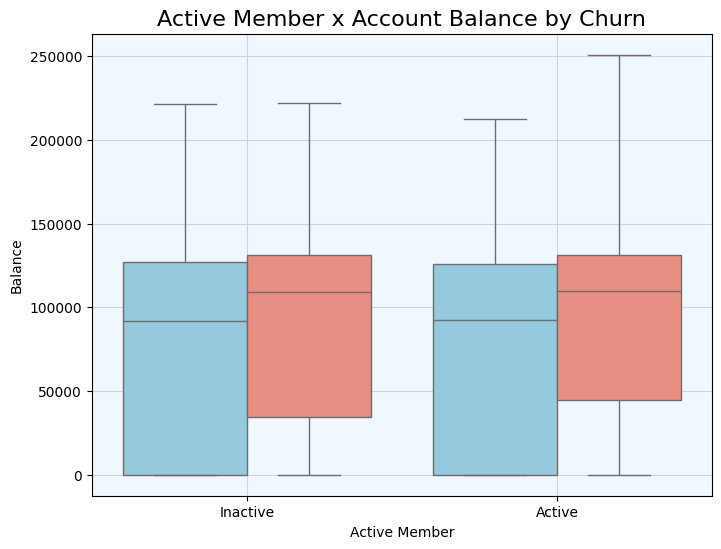

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    x='active_member',
    y='balance',
    hue='churn',
    data=Churn,
    ax=ax,
    palette=['skyblue', 'salmon'],
    legend=False,
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Active Member x Account Balance by Churn', fontsize=16)
ax.set_ylabel('Balance')
ax.set_xlabel('Active Member')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Inactive', 'Active'])

plt.show()

***Insights***:
1. Customers with **higher balances are more likely to churn**.
2. This pattern persists across both active and inactive segments
3. Balance shows a consistent positive relationship with churn, particularly when combined with **engagement signals**.

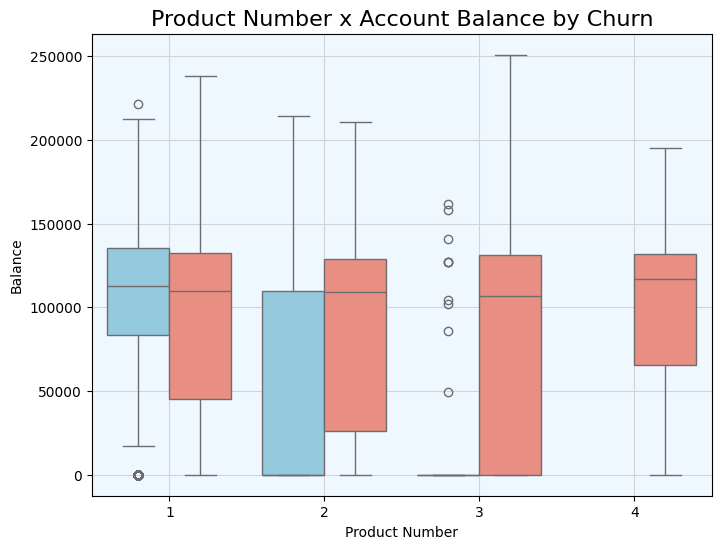

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    x='products_number',
    y='balance',
    hue='churn',
    data=Churn,
    ax=ax,
    palette=['skyblue', 'salmon'],
    legend=False,
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Product Number x Account Balance by Churn', fontsize=16)
ax.set_ylabel('Balance')
ax.set_xlabel('Product Number')

plt.show()

***Insights***:
1. Customers holding more products have **higher churn rates**.
2. Churn is especially high for customers with **three or more products**.
3. Among these customers, ***higher balances*** **are more common in the *churned group***.
4. This indicates that `product_number` **plays a stronger role than** `balance` in driving churn at higher product levels.

Are high-salary customers more stable?

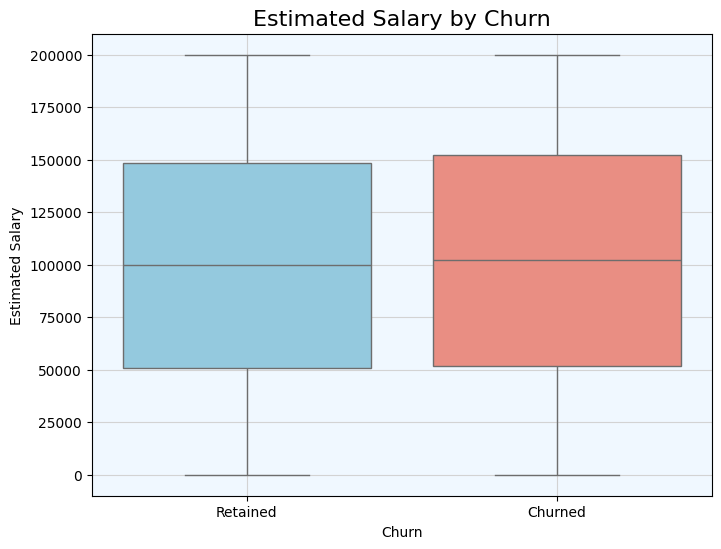

In [21]:
#visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    x='churn',
    y='estimated_salary',
    hue='churn',
    data=Churn,
    ax=ax,
    palette=['skyblue', 'salmon'],
    legend=False,
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Estimated Salary by Churn', fontsize=16)
ax.set_xlabel('Churn')
ax.set_ylabel('Estimated Salary')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Retained', 'Churned'])

plt.show()

Does low credit score correlate with churn?

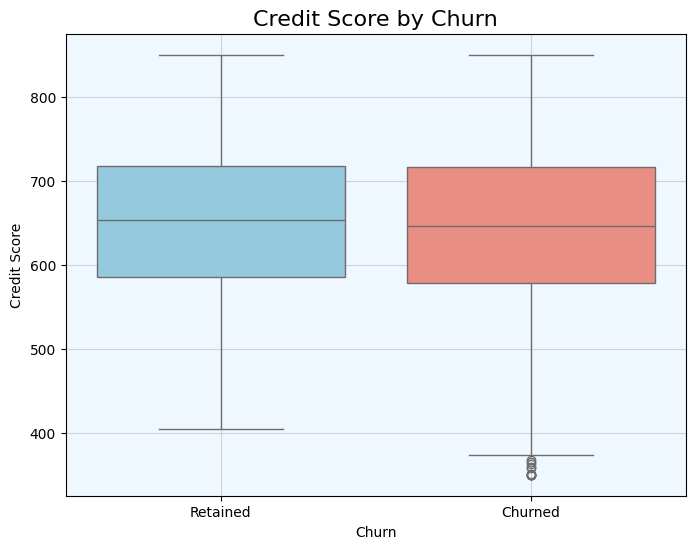

In [22]:
#visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(
    x='churn',
    y='credit_score',
    hue='churn',
    data=Churn,
    ax=ax,
    palette=['skyblue', 'salmon'],
    legend=False,
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Credit Score by Churn', fontsize=16)
ax.set_ylabel('Credit Score')
ax.set_xlabel('Churn')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Retained', 'Churned'])

plt.show()

#### 5. Product and Engagement Analysis
Do customers with more products churn less?

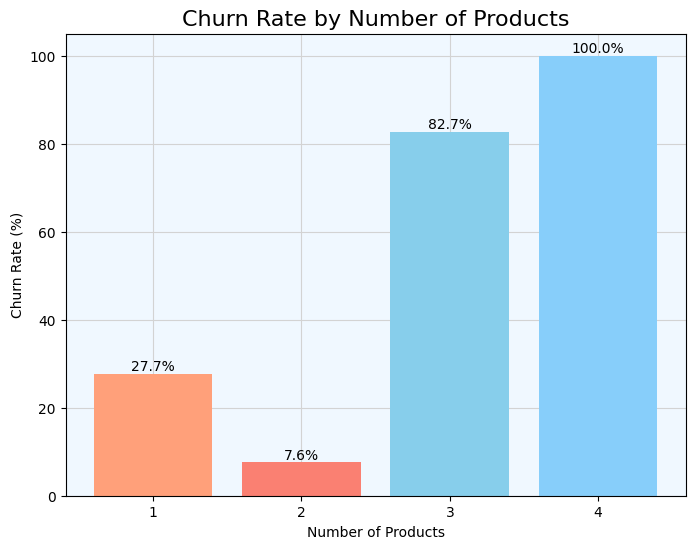

In [23]:
products_churn_pct = (
    Churn.groupby('products_number')['churn']
    .mean() * 100
)

# visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(
    products_churn_pct.index, 
    products_churn_pct.values,
    color=['lightsalmon', 'salmon', 'skyblue', 'lightskyblue'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Number of Products', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Number of Products')

ax.set_xticks([1, 2, 3, 4])

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()


Are inactive members more likely to churn?

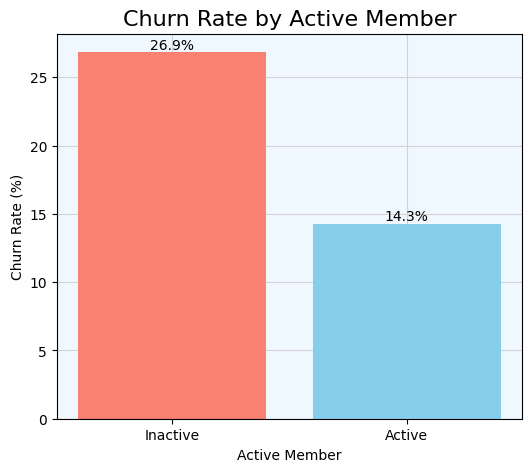

In [24]:
active_churn_pct = (
    Churn.groupby('active_member')['churn']
    .mean()
    .sort_index() * 100
)

# visualization
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    active_churn_pct.index, 
    active_churn_pct.values,
    color=['salmon', 'skyblue'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Active Member', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Active Member')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Inactive', 'Active'])

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()

Does having a credit card reduce churn?

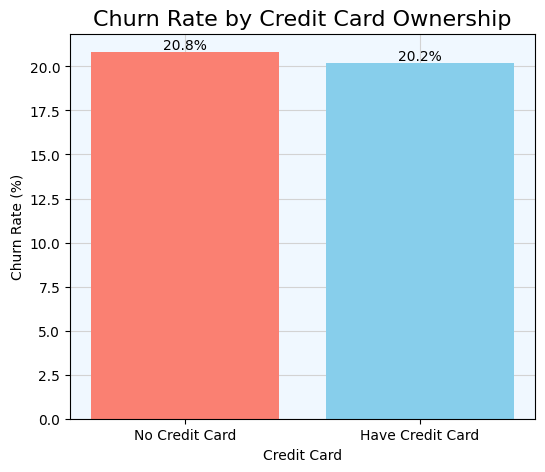

In [25]:
cc_churn_pct = (
    Churn.groupby('credit_card')['churn']
    .mean()
    .sort_index() * 100
)

# visualization
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    cc_churn_pct.index, 
    cc_churn_pct.values,
    color=['salmon', 'skyblue'],
    zorder=2
)
ax.grid(True, which='both', color='lightgrey', zorder=0)
ax.set_facecolor('aliceblue')

ax.set_title('Churn Rate by Credit Card Ownership', fontsize=16)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Credit Card')

ax.set_xticks([0, 1])
ax.set_xticklabels(['No Credit Card', 'Have Credit Card'])

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom')

plt.show()


## Initial Correlation Analysis (Raw Features)

In [26]:
#encode categorical features
categorical_cols = ['country', 'gender']
encoded_df = pd.get_dummies(Churn[categorical_cols], drop_first=True)

#prepare numeric features
numeric_df = Churn.select_dtypes(include=['int64', 'float64']).copy()

#combine numeric and encoded
corr_df = pd.concat([numeric_df, encoded_df], axis=1)

#compute correlation with churn only
churn_corr = corr_df.corr()['churn'].sort_values(ascending=False)

#remove self-correlation
churn_corr = churn_corr.drop('churn')

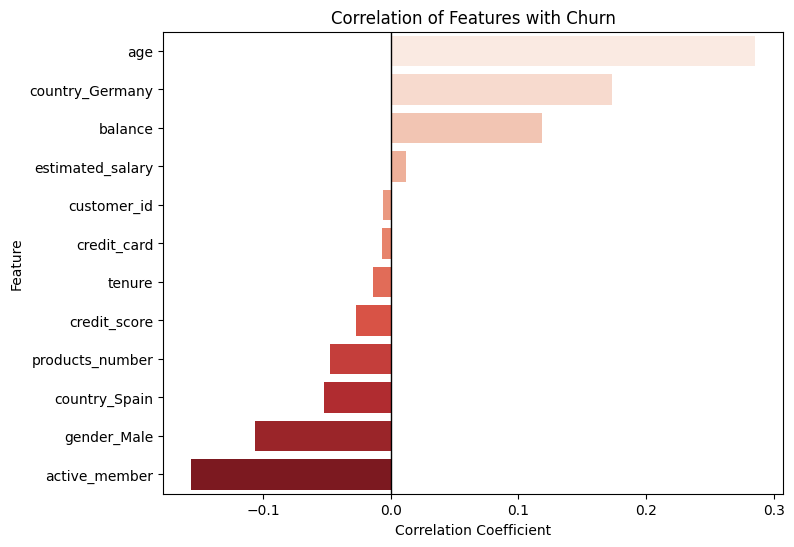

In [27]:
#visualization
plt.figure(figsize=(8, 6))

sns.barplot(
    x=churn_corr.values,
    y=churn_corr.index,
    palette='Reds',
    hue=churn_corr.index
)

plt.title("Correlation of Features with Churn")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")

plt.axvline(0, color='black', linewidth=1)

plt.show()

## Feature Engineering
Taking into consideration the insights we have from the previous **EDA**, here are the new features we're going to derive to enhance the model:

#### 1. Single Product Flag

   After analyzing **churn rate by number of products** (*Section 5*), we observed that customers holding **only one product churn significantly more** than multi-product customers; therefore, we derived a `single_product_flag` to explicitly capture this high-risk group in a simpler way.

In [28]:
#derive single_product_flag
Churn['single_product_flag'] = (Churn['products_number'] == 1).astype(int)

#### 2. Low Engagement Risk Flag

Customers with weak engagement signals are more likely to leave; therefore, we derived a `low_engagement_risk_flag` to capture this group.

In [29]:
#identify customers at higher churn risk with low_engagement_risk_flag
Churn['low_engagement_risk_flag'] = (
    ((Churn['products_number'] <= 1) & 
     (Churn['balance'] < Churn['balance'].median()) & 
     (Churn['active_member'] == 0))
).astype(int)

#### 3. High Value Risk Flag

EDA showed that some high-value customers still churn; therefore, we introduced `high_value_risk_flag` to help the model identify potentially **costly churn cases** that deserve *special attention*.

In [30]:
#identify high-value customers who might still be at risk
Churn['high_value_risk_flag'] = (
    (Churn['products_number'] >= 3) &
    (Churn['balance'] > Churn['balance'].median())
).astype(int)

In [31]:
#prepare numeric features
numeric_df = Churn.select_dtypes(include=['int64', 'float64']).copy()

#combine numeric and encoded
corr_df = pd.concat([numeric_df, encoded_df], axis=1)

#compute correlation with churn only
churn_corr = corr_df.corr()['churn'].sort_values(ascending=False)

#remove self-correlation
churn_corr = churn_corr.drop('churn')

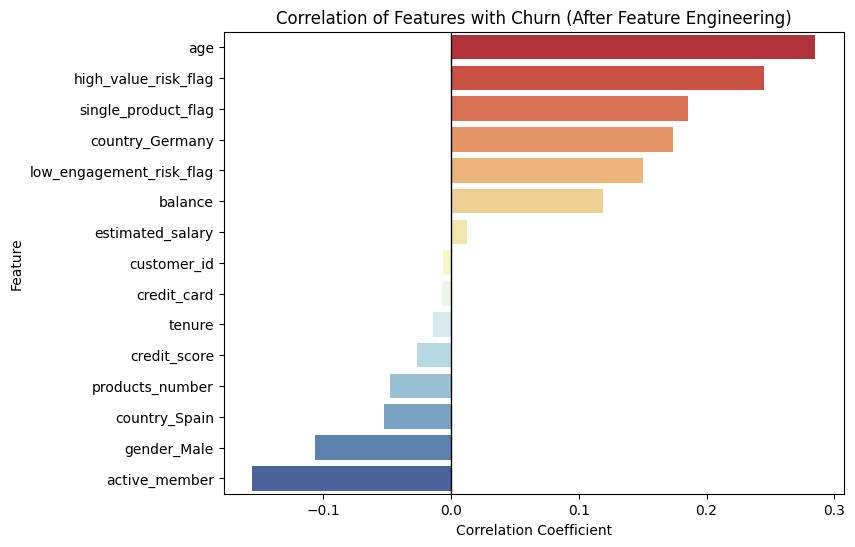

In [32]:
#visualization
plt.figure(figsize=(8, 6))

sns.barplot(
    x=churn_corr.values,
    y=churn_corr.index,
    palette='RdYlBu',
    hue=churn_corr.index
)

plt.title("Correlation of Features with Churn (After Feature Engineering)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")

plt.axvline(0, color='black', linewidth=1)

plt.show()

## Churn Prediction Model

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#### 1. Feature Selection

We use features derived from the EDA insights that showed meaningful relationships with churn.

In [34]:
#features used for modeling
features = [
    'age',
    'tenure',
    'balance',
    'estimated_salary',
    'active_member',
    'credit_card',
    'single_product_flag',
    'low_engagement_risk_flag',
    'high_value_risk_flag',
    'country',
]
X = Churn[features]

#target variable
y = Churn['churn']

#### 2. Encoding Categorical Variables

Since **Logistic Regression** requires numerical inputs, we encode categorical features.

* `country` → One-Hot Encoding

* Drop first category to avoid multicollinearity

In [35]:
#encode categorical features
X = pd.get_dummies(
    X,
    columns=['country'],
    drop_first=True
)

#### 3. Feature Scaling

Logistic Regression is sensitive to feature scale. Hence, we scale numerical features, but not binary flags.

In [36]:
numeric_features = ['age', 'tenure', 'balance', 'estimated_salary']

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

#### 4. Train-Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### 5. Logistic Regression Model Training

In [38]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

#train the model
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

#### 6. Model Evaluation

In [39]:
#confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm

array([[1192,  401],
       [ 116,  291]])

In [40]:
#classification report (precision / recall)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1593
           1       0.42      0.71      0.53       407

    accuracy                           0.74      2000
   macro avg       0.67      0.73      0.68      2000
weighted avg       0.81      0.74      0.76      2000



In [41]:
#ROC-AUC Score
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

np.float64(0.8066865016017559)

#### 7. Model Interpretability

In [42]:
#feature coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
8,high_value_risk_flag,4.393127
6,single_product_flag,1.121519
9,country_Germany,0.912290
0,age,0.770013
7,low_engagement_risk_flag,0.430884
10,country_Spain,0.088498
3,estimated_salary,0.068011
2,balance,-0.012908
1,tenure,-0.026696
5,credit_card,-0.114675


## Final Insights & Business Actions
Based on the model interpretability results, we identify the following **key churn drivers** and propose **business actions** to reduce customer attrition.

#### 1. Protect High-Value Customers

***Insight***:

`high_value_risk_flag` has the strongest positive coefficient (**+4.37**), indicating that customers with **high balances and multiple products** are at significant churn risk.

***Business Action***:
* Create a VIP retention program for high-value customers
* Offer personalized incentives

#### 2. Increase Product Adoption for Single-Product Customers

***Insight***:

`single_product_flag` (**+1.14**) strongly increases churn probability.

***Business Action***:
* Educate customers on benefits of multi-product usage

#### 3. Country-Specific Retention Strategies

***Insight***:

Customers in **Germany** (**+0.91**) and **Spain** (**+0.09**) show higher churn risk.

***Business Action***:
* Run localized marketing and retention offers
* Review service quality and customer experience by region

#### 4. Address Age-Related Churn Risk

***Insight***:

`age` (**+0.77**) shows that churn risk increases with customer age.

***Business Action***:
* Design **age-specific engagement strategies**
* Provide simplified digital experiences for older customers
* Offer retirement-friendly or low-risk financial products

#### 5. Re-Engage Low-Engagement Customers Early

***Insight***:

With (**+0.41**), `low_engagement_risk_flag` confirms that inactive customers with low balances are more likely to churn.

***Business Action***:
* Send re-engagement nudges (app usage reminders)

#### 6. Encourage Active Membership

***Insight***:

`active_member` has a strong negative coefficient (**−0.79**), meaning active customers are **much less likely to churn**.

***Business Action***:
* Reward activity
* Introduce loyalty programs tied to engagement
* Improve in-app experience to encourage frequent use

#### 7. Credit Card Adoption & Balance

***Insight***:

`credit_card` (**−0.11**) slightly reduces churn risk, and `balance` alone is not a strong churn driver (**−0.006**).

***Business Action***:
* Offer low-fee or entry-level credit cards
* Educate customers on card benefits
* Do **not** rely solely on balance to assess churn risk